In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [ ]:
nltk.download("vader_lexicon", download_dir="./.venv/nltk_data")

In [50]:
df = pd.read_csv("./Reviews.csv")
sub_df = df.head(500)

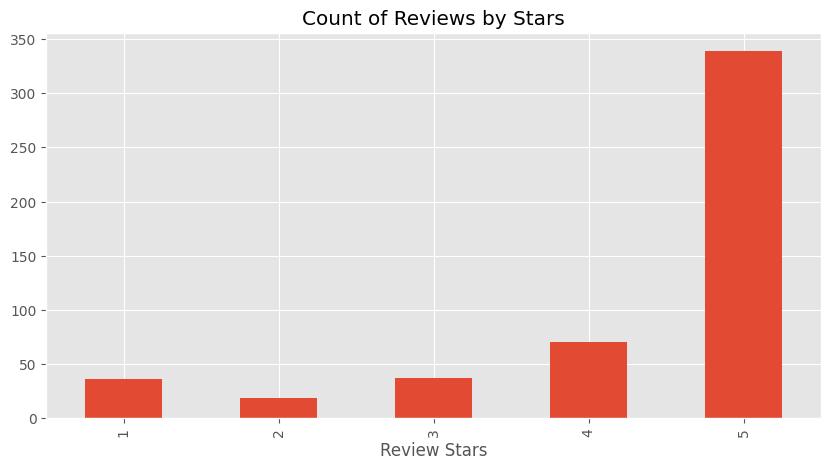

In [51]:
ax = sub_df["Score"].value_counts() \
                .sort_index() \
                .plot(kind="bar", 
                      title="Count of Reviews by Stars", 
                      figsize=(10,5))
ax.set_xlabel("Review Stars")
plt.show()

In [52]:
example = sub_df["Text"][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [54]:
tokens = nltk.word_tokenize(example) # NLTK uses PunktSentenceTokenizer
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [56]:
pos_tags = nltk.pos_tag(tokens) # Part of speech tagging, each word relates to a "part of speech", such as Determiner (What is being addressed), adjective, etc
pos_tags[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [57]:
entities = nltk.chunk.ne_chunk(pos_tags) # Chunking is grouping related words
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Using VADER (Valence Aware Dictionary and sEntiment Reasoner)
- Uses a bag of words approach
  1. Remove stop words (and, the, etc)
  2. Each word is scored and aggregated to a total score

In [59]:
sia = SentimentIntensityAnalyzer()

In [60]:
sia.polarity_scores("I am so happy") # Compound is -1 to 1 to represent the whole sentence

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [63]:
sia.polarity_scores("This is the worst thing ever!")

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [64]:
sia.polarity_scores("This is the best and worst thing ever!")

{'neg': 0.281, 'neu': 0.411, 'pos': 0.308, 'compound': 0.1007}

In [62]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [65]:
res = {}
for i, row in tqdm(sub_df.iterrows(), total=len(sub_df)):
    text = row["Text"]
    curr_id = row["Id"]
    res[curr_id] = sia.polarity_scores(text)


res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename({"index": "Id"}, axis=1)
res_df = res_df.merge(sub_df, how="left")

  0%|          | 0/500 [00:00<?, ?it/s]

In [66]:
res_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


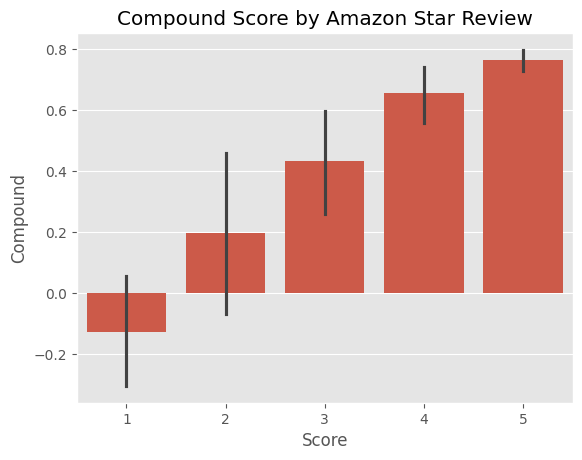

In [72]:
ax = sns.barplot(data=res_df, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
ax.set_ylabel("Compound")
plt.show()

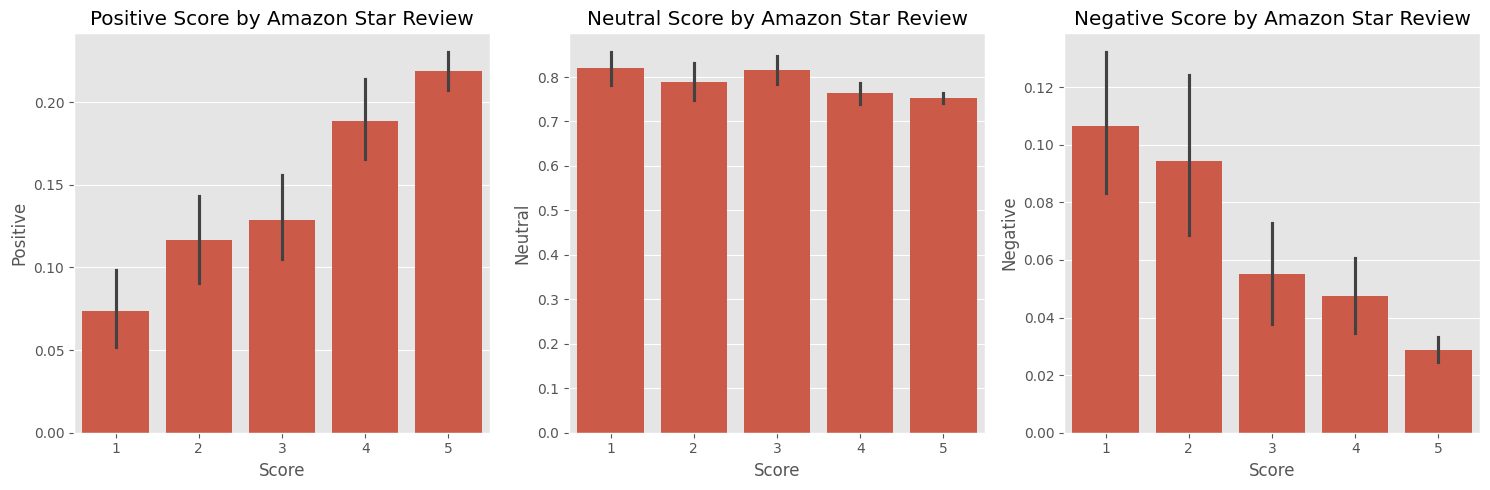

In [75]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax1 = sns.barplot(data=res_df, x="Score", y="pos", ax=axs[0])
ax1.set_title("Positive Score by Amazon Star Review")
ax1.set_ylabel("Positive")
ax2 = sns.barplot(data=res_df, x="Score", y="neu", ax=axs[1])
ax2.set_title("Neutral Score by Amazon Star Review")
ax2.set_ylabel("Neutral")
ax2 = sns.barplot(data=res_df, x="Score", y="neg", ax=axs[2])
ax2.set_title("Negative Score by Amazon Star Review")
ax2.set_ylabel("Negative")
plt.tight_layout()
plt.show()

As mentioned before, VADER scores individual words and not group of words as a whole! -> Take for example, if a comment was meant to be sarcastic and imply goodness, VADER will not be able to pick up on this context